<font size=6><b>Data Driven Golf: Which skills have the biggest impact?<b/></font>
<br><br>
<font size=4>In this notebook, my aim is to create a model that can predict the amount of money earned and number of top 10 placements a player has earned over the course of a season using season long statistics such as fairway percentage and average putts per round. The final goal will be to determine which skill (driving, putting, approach, chipping) has the greatest impact on money made and performance based on feature importance using SHapley Additive exPlantions (SHAP).</font>
<br>
<font size=4><b>Data set: </b></font>
<font size=4>https://www.kaggle.com/datasets/jmpark746/pga-tour-data-2010-2018</font>
<br><br>

<div style="display: flex; justify-content: space-between;">
  <div style="flex: 1; margin-right: 50px;">
      <font size=4><b>Features:</b></font>
    <ul>
      <li>Rounds</li>
      <li>Fairway %</li>
      <li>AVG driving distance</li>
      <li>Green in reg. %</li>
      <li>AVG putts per round</li>
      <li>AVG scrambling %</li>
      <li>AVG round score</li>
      <li>AVG SG putting</li>
      <li>AVG SG total</li>
      <li>AVG SG off the tee</li>
      <li>AVG SG approach</li>
      <li>AVG SG around green</li>
    </ul>
  </div>
  <div style="flex: 1;">
      <font size=4><b>Outcome Variables:</b></font>
    <ul>
      <li>Points</li>
      <li>Wins</li>
      <li>Top 10s</li>
      <li>Money</li>
    </ul>
  </div>
</div>
<br>
    <font size=4><b>Key:</b></font>
<br>
<font size=3>reg. = Regulation</font>
<br>
<font size=3>AVG = Average</font>
<br>
<font size=3>SG = Strokes Gained on field*</font>
<br><br>
    <font size=3>*Video linked for further explanation in results section</font>

<font size = 6>Loading and Cleaning Dataset</font>

In [1]:
# import basic packages
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# load in dataset
raw_data_df = pd.read_csv("2010_2018\pgaTourData.csv")
raw_data_df.head()

,Player Name,Rounds,Fairway Percentage,Year,Avg Distance,gir,Average Putts,Average Scrambling,Average Score,Points,Wins,Top 10,Average SG Putts,Average SG Total,SG:OTT,SG:APR,SG:ARG,Money
0,Henrik Stenson,60.0,75.19,2018,291.5,73.51,29.93,60.67,69.617,868,NaN,5.0,-0.207,1.153,0.427,0.960,-0.027,"$2,680,487"
1,Ryan Armour,109.0,73.58,2018,283.5,68.22,29.31,60.13,70.758,"1,006",1.0,3.0,-0.058,0.337,-0.012,0.213,0.194,"$2,485,203"
2,Chez Reavie,93.0,72.24,2018,286.5,68.67,29.12,62.27,70.432,"1,020",NaN,3.0,0.192,0.674,0.183,0.437,-0.137,"$2,700,018"
3,Ryan Moore,78.0,71.94,2018,289.2,68.80,29.17,64.16,70.015,795,NaN,5.0,-0.271,0.941,0.406,0.532,0.273,"$1,986,608"
4,Brian Stuard,103.0,71.44,2018,278.9,67.12,29.11,59.23,71.038,421,NaN,3.0,0.164,0.062,-0.227,0.099,0.026,"$1,089,763"


<font size = 5>Cleaning Data</font>

In [43]:
# cleaning data
cleaned_df = pd.DataFrame(raw_data_df)

# 1. Remove rows with too much missing data
first_nan_index = raw_data_df['Fairway Percentage'].isna().idxmax()
cleaned_df = raw_data_df.iloc[:first_nan_index]

# 2. Remove all rows with missing Money value
cleaned_df = cleaned_df.dropna(subset=['Money'])

# 3. Replace all empty cells in Wins and Top 10 with zeros
cleaned_df['Wins'] = cleaned_df['Wins'].fillna(0)
cleaned_df['Top 10'] = cleaned_df['Top 10'].fillna(0)

# 4. Remove punctuation from Money column and Points column
cleaned_df['Money'] = cleaned_df['Money'].replace({'\$':'', ',':''}, regex=True).astype(int)
cleaned_df['Points'] = cleaned_df['Points'].replace({',':''}, regex=True).astype(int)

In [4]:
print(cleaned_df.shape)
cleaned_df.head()

(1674, 18)


,Player Name,Rounds,Fairway Percentage,Year,Avg Distance,gir,Average Putts,Average Scrambling,Average Score,Points,Wins,Top 10,Average SG Putts,Average SG Total,SG:OTT,SG:APR,SG:ARG,Money
0,Henrik Stenson,60.0,75.19,2018,291.5,73.51,29.93,60.67,69.617,868,0.0,5.0,-0.207,1.153,0.427,0.960,-0.027,2680487
1,Ryan Armour,109.0,73.58,2018,283.5,68.22,29.31,60.13,70.758,1006,1.0,3.0,-0.058,0.337,-0.012,0.213,0.194,2485203
2,Chez Reavie,93.0,72.24,2018,286.5,68.67,29.12,62.27,70.432,1020,0.0,3.0,0.192,0.674,0.183,0.437,-0.137,2700018
3,Ryan Moore,78.0,71.94,2018,289.2,68.80,29.17,64.16,70.015,795,0.0,5.0,-0.271,0.941,0.406,0.532,0.273,1986608
4,Brian Stuard,103.0,71.44,2018,278.9,67.12,29.11,59.23,71.038,421,0.0,3.0,0.164,0.062,-0.227,0.099,0.026,1089763


<font size = 6>Exploratory Data Analysis</font> <br>
<font size = 4>Overview of continuous outcome variables</font>

In [5]:
cleaned_df['Points'].describe()
# right skew, which makes sense considering points are given exponentially based on placement

count    1674.000000
mean      631.125448
std       452.741472
min         3.000000
25%       322.000000
50%       530.000000
75%       813.750000
max      4169.000000
Name: Points, dtype: float64

In [6]:
cleaned_df['Money'].describe()
# mean higher than median indicating right skewed distribution, max is almost 10x mean

count    1.674000e+03
mean     1.488682e+06
std      1.410333e+06
min      2.465000e+04
25%      5.656412e+05
50%      1.046144e+06
75%      1.892478e+06
max      1.203046e+07
Name: Money, dtype: float64

In [7]:
cleaned_df['Top 10'].describe()
# slight right skew suggested, max is very high

count    1674.000000
mean        2.337515
std         2.060691
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        14.000000
Name: Top 10, dtype: float64

In [44]:
cleaned_df['Wins'].describe()
# it makes sense that these values are so low because there are only 36 official tournaments per year and around 200 players
# only 17 seasons have ended with 5 or more wins, 10 of those belong to Tiger Woods

count    1674.000000
mean        0.206691
std         0.516601
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         5.000000
Name: Wins, dtype: float64

<font size = 5>Correlation Matrix (its quite big)</font>

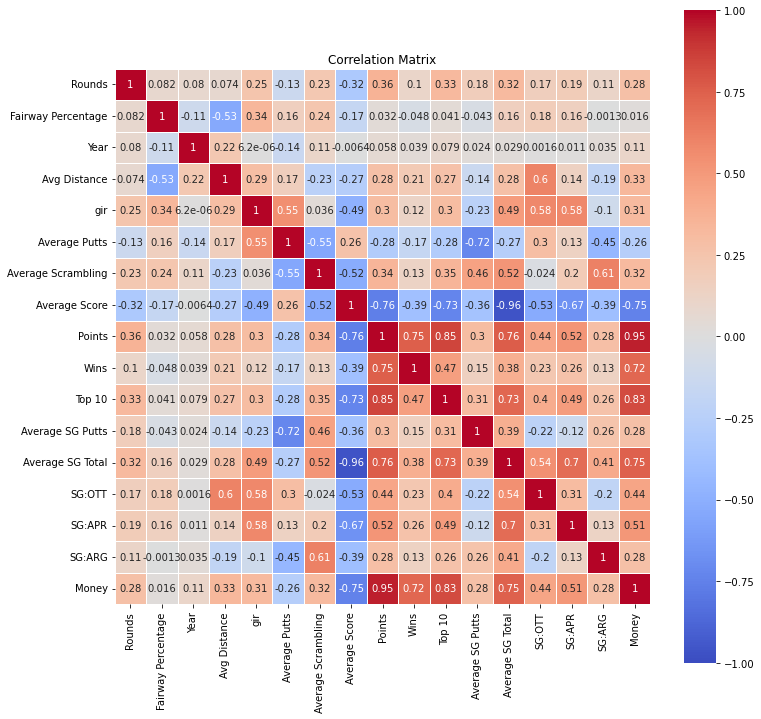

In [9]:
correlation_matrix = cleaned_df.corr()

# create figure
plt.figure(figsize=(12, 12))

# heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmax=1.0, vmin=-1.0, center=0, square=True, linewidths=.5)

plt.title('Correlation Matrix')
plt.show()

<font size=4>Upon initial analysis, among the SG features, the four different skills are ranked in order of most to least associated with our outcome variables: approach, driving, putting, chipping. This is actually consistent with all four of the outcome variables: Points, Wins, Top 10, and Money (with the exception of putting and chipping being seemingly tied in last for Money).

<font size = 5>Graphs to Further Explore Relationships</font><br>
<font size = 3>The four outcome variables I will be exploring are: Points, Wins, Top 10, and Money</font><br>
<font size = 3>Starting with histograms of our features:</font>


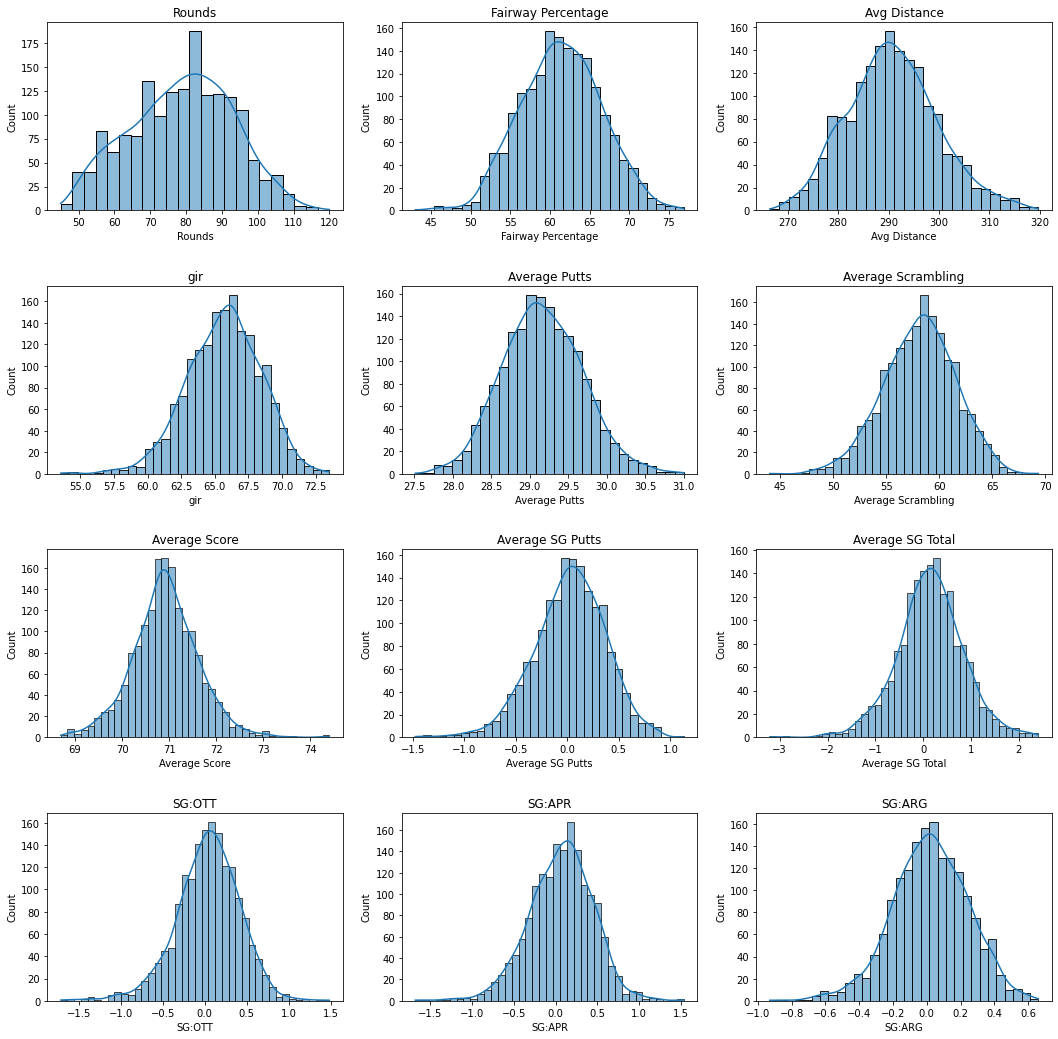

In [10]:
# create the subplots
f, ax = plt.subplots(nrows=4, ncols=3, figsize=(18, 18))

# list of columns to plot
columns = ['Rounds', 'Fairway Percentage', 'Avg Distance', 'gir', 'Average Putts',
           'Average Scrambling', 'Average Score', 'Average SG Putts',
           'Average SG Total', 'SG:OTT', 'SG:APR', 'SG:ARG']

# initialize row and column indices
row = 0
col = 0

# loop through the columns and create a histogram for each
for i, column in enumerate(columns):
    g = sns.histplot(cleaned_df[column], kde=True, ax=ax[row][col])
    g.set(title=column)
    
    # update column index
    col += 1
    
    # if we've reached the end of a row, reset column index and move to next row
    if col == 3:
        col = 0
        row += 1

# adjust layout to add space between plots
plt.subplots_adjust(hspace=0.4)

# show the plots
plt.show()

<font size = 4>Now histograms for our outcome variables:</font>

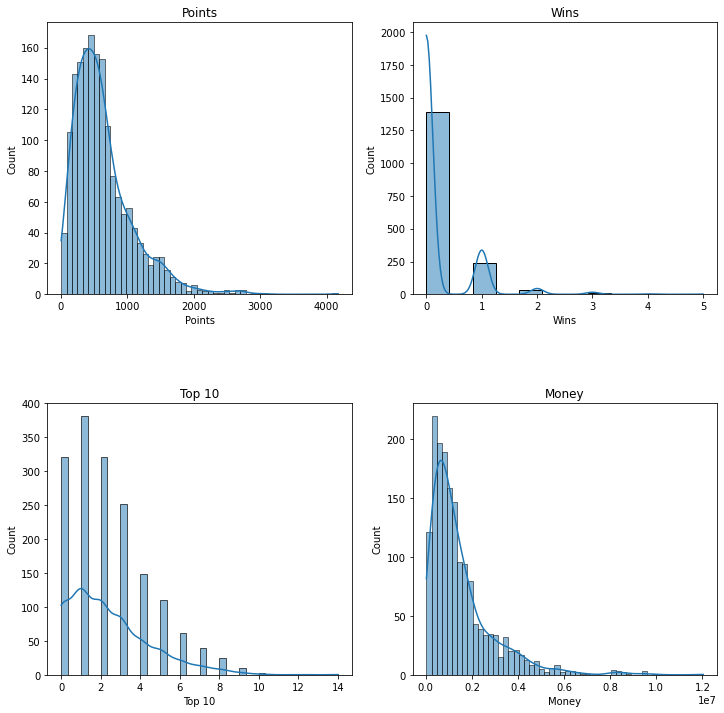

In [11]:
# create the subplots
f2, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

# list of columns to plot
columns = ['Points', 'Wins', 'Top 10', 'Money']

# initialize row and column indices
row = 0
col = 0

# loop through the columns and create a histogram for each
for i, column in enumerate(columns):
    g = sns.histplot(cleaned_df[column], kde=True, ax=ax[row][col])
    g.set(title=column)
    
    # update column index
    col += 1
    
    # if we've reached the end of a row, reset column index and move to next row
    if col == 2:
        col = 0
        row += 1

# adjust layout to add space between plots
plt.subplots_adjust(hspace=0.4)

# show the plots
plt.show()

<font size = 4>Next I would like to analyze the amount of wins and top 10s in each season using pie charts:</font>

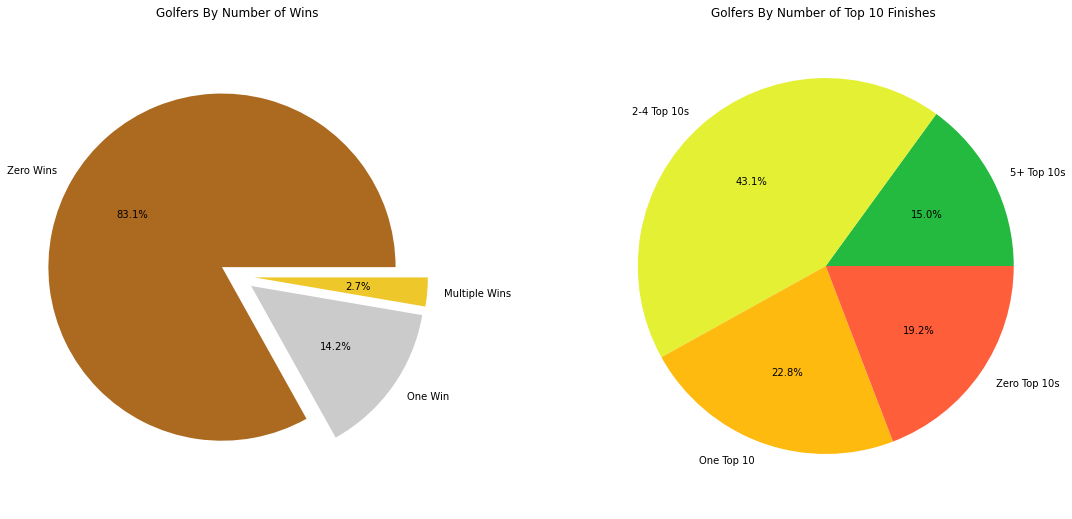

In [12]:
# count golfers with zero, one, and multiple wins/top 10s
zero_wins = cleaned_df[cleaned_df['Wins'] == 0].shape[0]
one_win = cleaned_df[cleaned_df['Wins'] == 1].shape[0]
multiple_wins = cleaned_df[cleaned_df['Wins'] > 1].shape[0]

zero_top10 = cleaned_df[cleaned_df['Top 10'] == 0].shape[0]
one_top10 = cleaned_df[cleaned_df['Top 10'] == 1].shape[0]
two_to_four_top10 = cleaned_df[(cleaned_df['Top 10'] >= 2) & (cleaned_df['Top 10'] <= 4)].shape[0]
five_or_more_top10 = cleaned_df[cleaned_df['Top 10'] >= 5].shape[0]

# Create the subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 9))

# create labels for pie charts
labels = ['Zero Wins', 'One Win', 'Multiple Wins']
values = [zero_wins, one_win, multiple_wins]
labels10 = ['5+ Top 10s', '2-4 Top 10s', 'One Top 10', 'Zero Top 10s']
values10 = [five_or_more_top10, two_to_four_top10, one_top10, zero_top10]

# colors and explode settings
colors = ["#ac6a20", "#cbcbcb", "#eec82a"]
explode = [0.1, 0.1, 0.1]
colors10 = ["#24b93f", "#e4f034", "#ffba10", "#ff5e3a"]
explode10 = [0, 0, 0, 0]

# plot the first pie chart
ax[0].pie(values, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%')
ax[0].set_title('Golfers By Number of Wins')
ax[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# plot the second pie chart
ax[1].pie(values10, explode=explode10, labels=labels10, colors=colors10, autopct='%1.1f%%')
ax[1].set_title('Golfers By Number of Top 10 Finishes')
ax[1].axis('equal')

# adjust layout
plt.subplots_adjust(wspace=0.4)

plt.show()

<font size = 3>As we can see above, over the course of 8 seasons, 83% of golfer's seasons were ended without a win, while only 17% of golfer's seasons did contain a win. An even smaller 2.7% of seasons contained multiple wins (Note: this chart does not account for golfers who played multiple seasons. for example, if a golfer finished a season with one win, and 3 seasons without a win, they are contributing 3 data points to the zero wins section and one data point to the one win section. This does not matter much for my purposes as I am considering each season by each golfer an independent data point, however it is important to be aware of). In contrast to these statistics for wins on tour, the breakdown of top 10s is much more diverse. This is why I believe it will be a better indicator for skill/performance when conducting my analysis. Having a wider range and more diversity in the continuous variable, I believe, will remove certain factors such as luck when considering performance. This diversity will also give my model more intricacy and information to look into and more data to detect patterns.</font>

<font size = 3>The other outcome variables we need to talk about are points and money made. Points are referring to FedEx cup points which are awarded to players throughout the season for their performances, with higher placements making exponentially more money and more prestegious tournaments being worth more points due to them attracting greater competition (This analysis would be more complicated if done with more recent data because of the induction of the LIV golf league. This new league split up players for most tournaments, while all players still compete in the largest tournaments). I will not use points in my analysis because they are abstract and difficult to understand compared to a concept that everyone understands: money! This leads me to my final two outcome varibles being analyzed: Top 10s and Money. These two are the most useful numbers, and also easy to understand for the average person.</font>

<font size = 6>Time to Make a Model!</font>
<br>
<font size = 4>Model tested: Gradient Boosting Regression</font>

In [13]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.svm import SVR
from xgboost import XGBRegressor
cleaned_df.head()

,Player Name,Rounds,Fairway Percentage,Year,Avg Distance,gir,Average Putts,Average Scrambling,Average Score,Points,Wins,Top 10,Average SG Putts,Average SG Total,SG:OTT,SG:APR,SG:ARG,Money
0,Henrik Stenson,60.0,75.19,2018,291.5,73.51,29.93,60.67,69.617,868,0.0,5.0,-0.207,1.153,0.427,0.960,-0.027,2680487
1,Ryan Armour,109.0,73.58,2018,283.5,68.22,29.31,60.13,70.758,1006,1.0,3.0,-0.058,0.337,-0.012,0.213,0.194,2485203
2,Chez Reavie,93.0,72.24,2018,286.5,68.67,29.12,62.27,70.432,1020,0.0,3.0,0.192,0.674,0.183,0.437,-0.137,2700018
3,Ryan Moore,78.0,71.94,2018,289.2,68.80,29.17,64.16,70.015,795,0.0,5.0,-0.271,0.941,0.406,0.532,0.273,1986608
4,Brian Stuard,103.0,71.44,2018,278.9,67.12,29.11,59.23,71.038,421,0.0,3.0,0.164,0.062,-0.227,0.099,0.026,1089763


In [14]:
# setting up data to be split
X = cleaned_df.drop(['Player Name', 'Points', 'Wins', 'Top 10', 'Money'], axis=1) #'Player Name', 'Rounds', 'Year', 'Average Score', 'Average SG Total', 
y1 = cleaned_df['Top 10']
y2 = cleaned_df['Money']

# splitting data
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y1, test_size = 0.2, random_state = 15)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2, test_size = 0.2, random_state = 15)

<font size=6>Training, Testing, and Metrics</font>

In [15]:
# create and train GBR
xgbr1 = XGBRegressor(verbosity=0)
xgbr2 = XGBRegressor(verbosity=0)

In [16]:
# training for top 10s
xgbr1.fit(X_train1, y_train1)
print("Top 10s testing score:", xgbr1.score(X_test1, y_test1))

# training for money
xgbr2.fit(X_train2, y_train2)
print("Money testing score:", xgbr2.score(X_test2, y_test2))

Top 10s testing score: 0.5583995912942372
Money testing score: 0.7639851720000876


In [18]:
from sklearn.metrics import mean_squared_error

# other metrics for top 10s
y_pred1 = xgbr1.predict(X_test1)

mse1 = mean_squared_error(y_test1, y_pred1)
print("Top 10s MSE:", mse1)
print("Top 10s RMSE:", mse1**(1/2))

# other metrics for top money
y_pred2 = xgbr2.predict(X_test2)

mse2 = mean_squared_error(y_test2, y_pred2)
print("Money MSE:", mse2)
print("Top 10s RMSE:", mse2**(1/2))
# top 10s model looks to be on average 1.37 top 10 placements off from the actual value
# money model looks to be on average $711,645 off

Top 10s MSE: 1.8767535337915908
Top 10s RMSE: 1.3699465441365188
Money MSE: 506439064092.58636
Top 10s RMSE: 711645.3218370696


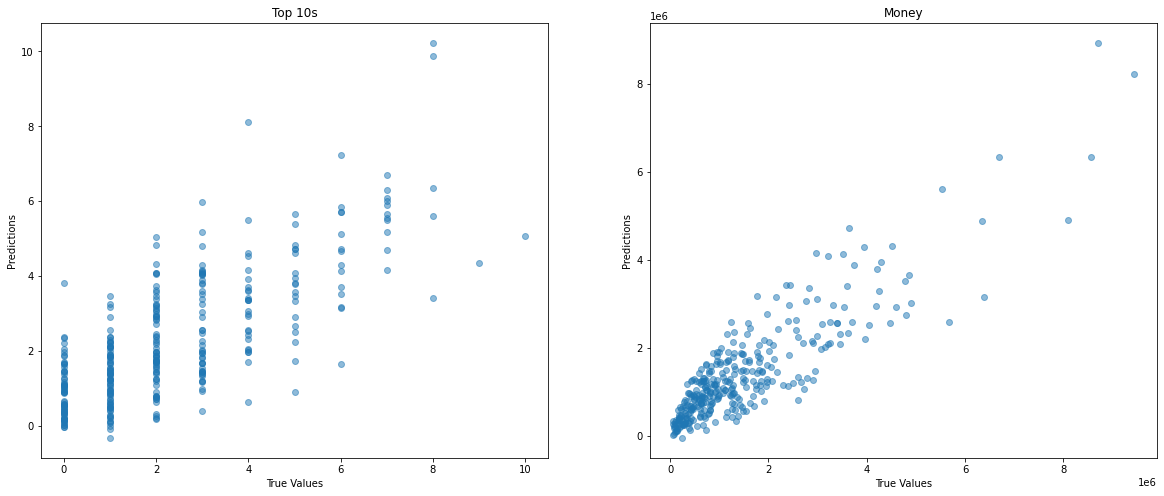

In [19]:
plt.figure(1, figsize=(20, 8))

# plot of top 10s
plt.subplot(1,2,1)
plt.scatter(y_test1, y_pred1, alpha=0.5)
plt.title("Top 10s")
plt.xlabel('True Values')
plt.ylabel('Predictions')

# plot of money
plt.subplot(1,2,2)
plt.scatter(y_test2, y_pred2, alpha=0.5)
plt.title("Money")
plt.xlabel('True Values')
plt.ylabel('Predictions')

plt.show()
# money has a tighter spread which makes sense looking at our r2 values above

<br>
<font size=5>Hyperparameter optimization using GridSearchCV</font>

In [20]:
from sklearn.model_selection import GridSearchCV

# different parameter combinations for testing
param_grid = {
    "n_estimators":[100, 200, 500], "max_depth":[5, 10, 20, 50], "learning_rate":[0.01, 0.05, 0.1]
}

# testing all combinations to find the best one
grid_search1 = GridSearchCV(xgbr1, param_grid, cv=3, scoring = "neg_mean_squared_error", return_train_score=True, verbose=1)

grid_search1.fit(X_train1, y_train1)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
            

In [21]:
final_xgbr1 = grid_search1.best_estimator_

In [22]:
# metrics for top 10s on optimized model
print(final_xgbr1.score(X_test1, y_test1))

final_y_pred1 = final_xgbr1.predict(X_test1)

final_mse1 = mean_squared_error(y_test1, final_y_pred1)
print("Top 10s MSE:", final_mse1)
print("Top 10s RMSE:", final_mse1**(1/2))
# new r2 score is slightly better than previos
# average distance from actual value was reduced from 1.37 to 1.29

0.6108900099307641
Top 10s MSE: 1.6536749842154745
Top 10s RMSE: 1.2859529479010787


In [23]:
grid_search2 = GridSearchCV(xgbr2, param_grid, cv=3, scoring = "neg_mean_squared_error", return_train_score=True, verbose=1)

grid_search2.fit(X_train2, y_train2)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
            

In [24]:
final_xgbr2 = grid_search2.best_estimator_

In [25]:
# metrics for money on optimized model
print(final_xgbr2.score(X_test2, y_test2))

final_y_pred2 = final_xgbr2.predict(X_test2)

final_mse2 = mean_squared_error(y_test2, final_y_pred2)
print("Money MSE:", final_mse2)
print("Money RMSE:", final_mse2**(1/2))
# r2 score has improved
# average distance from actual value was reduced from 711,645 to 705,442

0.7680815437704651
Money MSE: 497649096516.62537
Money RMSE: 705442.4827841214


<font size=6><b>Feature Importance Testing With SHAP</font>

In [28]:
import shap

# generating SHAP values for top 10s
explainer1 = shap.Explainer(xgbr1.predict,X_test1)
shap_values1 = explainer1(X_test1)

# generating SHAP values for money
explainer2 = shap.Explainer(xgbr2.predict,X_test2)
shap_values2 = explainer2(X_test2)

PermutationExplainer explainer: 336it [01:02,  4.61it/s]                         
PermutationExplainer explainer: 336it [01:01,  4.55it/s]                         


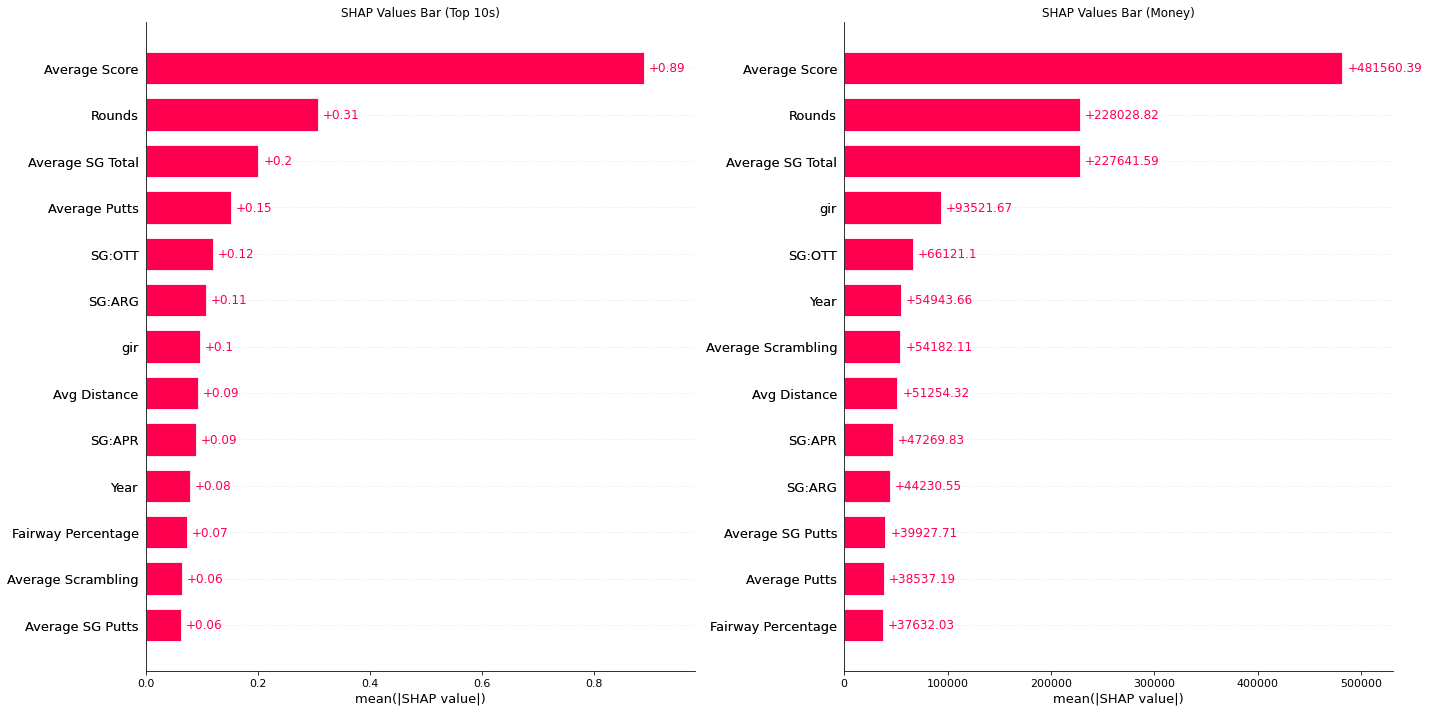

In [29]:
# Visualizing SHAP values with bar plot
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# top 10s
shap.plots.bar(shap_values1, max_display=13, show=False, ax=axs[0])
axs[0].set_title('SHAP Values Bar (Top 10s)')

# money
shap.plots.bar(shap_values2, max_display=13, show=False, ax=axs[1])
axs[1].set_title('SHAP Values Bar (Money)')

plt.tight_layout()

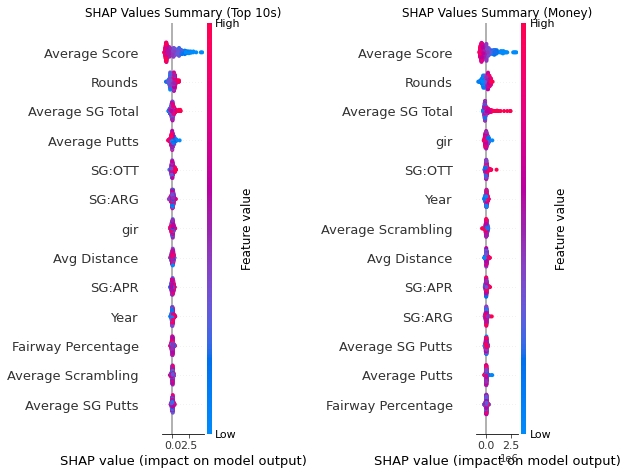

In [30]:
# Visualizing SHAP values with summary plot
fig, axs = plt.subplots(1, 2, figsize=(40, 10))

# top 10s
plt.sca(axs[0])
shap.summary_plot(shap_values1, X_test1, feature_names=X.columns.tolist(), show=False)
axs[0].set_title('SHAP Values Summary (Top 10s)')

# money
plt.sca(axs[1])
shap.summary_plot(shap_values2, X_test2, feature_names=X.columns.tolist(), show=False)
axs[1].set_title('SHAP Values Summary (Money)')

plt.tight_layout()
plt.subplots_adjust(wspace=5)


<font size=6><b>Results!</font>
<br>
<font size = 4>As it turns out, our results do point towards there being a difference in skills that result in an increase in top 10 finishes and money earned. As expected, Average Score and Average SG Total are right at the top of the list, along with Rounds. This makes sense considering that if a player plays in more tournaments (especially if they make the cut resulting in 2 extra rounds during that tournament), then they will make more money and have a greater chance of playing very well during a certain tournament, resulting in a top 10 finish. To simplify the analysis a little, I am going to say that metrics for driving include: SG:OTT, Avg Distance, and Fairway Percentage. Metrics for chipping include: Average Scrambling, SG:ARG. Metrics for approach include: gir, SG:APR, Average Putts (I explain this in the following section). And, metrics for putting include: Average SG Putts. If we look to the SHAP values for predicting top 10s specifically, Average Putts is weighted higher than SG off the tee, SG around the green, Average driving distance, and SG approach, suggesting that putting is the most important skill at an initial glance. However, the most interesting feature to look at here is Average SG putting, as it is the lowest of the bunch. This may not make sense at first, how can putting be the most important and least important skill at the same time? But, after further explanation of the concept of strokes gained, there is a simple answer. An amazing explanation of the concept is found in this YouTube video: https://www.youtube.com/watch?v=MeNHbGhPFzU. In this video, Columbia business school professor and creator of the strokes gained statistic, Mark Broadie, explains how SG works and why it is a superior, less misleading metric.</font>

<font size = 6>Why do Average Putts not tell the full story?</font>
<br>
<font size=4>In short, the answer is that Average Putts does not take into consideration how difficult each putt was. To maybe explain this concept a little better I will introduce two situations, where in both of which, each player will only take one putt. For example, if a player hits the ball from the fairway with an iron 150 yards away to within 3 feet on a hole, then putts the ball in with one putt. The strength of this golfer comes in the form of getting the ball close to the hole to begin with, not from their putting skill. In another scenario, a golfer hits the ball onto the green 20 feet from the hole, then gets the ball in the hole with one putt. This golfer's putting skill has done more of the work, as they sunk a more challenging putt. This is all to say that Average putts is a very misleading statistic and often means that a golfer is very strong in their approach game (landing the ball on the green close to the hole), rather than their putting. To summarize, a golfer with a low average putts (low is good) has a very strong approach game, while a golfer with a very high SG putting (high is good) has a very strong putting game.</font>

<font size=6>So what does this mean for our analysis?</font>
<br>
<font size=4>Because average putts indicates a strong approach game, our ranking for skills for performance is as follows:</font>
<br>
    <font size=4>1. Approach game</font><br>
    <font size=4>2. Driving (with distance mattering more than accuracy)</font><br>
    <font size=4>3. Chipping</font><br>
    <font size=4>4. Putting</font><br>
<br>
<font size=4>And for money:</font>
<br>
    <font size=4>1. Driving (with distance mattering more than accuracy)</font><br>
    <font size=4>2. Chipping</font><br>
    <font size=4>3. Approach</font><br>
    <font size=4>4. Putting (once again)</font><br>
<br>
<font size=4>As we can see, putting is dead last! But how can this be?? The saying has always been "drive for show, putt for dough", meaning that while driving may be impressive, the stronger putter will preform better and make more money. Given the popular saying, these results make no sense to the veteran golfer. However, as Mark Broadie will tell you (and as you have already heard if you watched the YouTube video), "unfortunately it's wrong". Anecdotally, all amateur golfers have experienced poor putting take the fun out of the game, however I'm willing to bet that, most of the time, the difficulty of these putts are not taken into consideration. High expectations lead many golfers to dissapointment and something that may remedy this is taking a look at PGA tour putting percentages (data taken from: https://golf.com/instruction/putting/pga-tour-putting-make-percentages-distance/).</font>
<br>
    <li><font size=4>3 feet: 99.4%</font></li>
    <li><font size=4>5 feet: 80.7%</font></li>
    <li><font size=4>8 feet: 52.9%</font></li>
    <li><font size=4>10 feet: 41.3%</font></li>
    <li><font size=4>15-20 feet: 18.3%</font></li>
<br>
<font size=4>These percentages show that for even the best golfers, making a putt is basically a coin flip from even as close as 8 feet, and absolutely much lower for the average golfer. This would indicate that a golfer's approach game matters much more than their putting skill (of course as long as they aren't completely terrible at putting).

<font size=4>For fans of the PGA tour, a little bit of analysis of the top golfers in the world from 2023 makes sense with these results. To corroborate my results I took the top 10 golfers from last year, according to Official World Golf Rankings (minus John Rahm as he plays for the LIV golf tour which would make comparing SG statistics inneffective as he plays against a different set of golfers). This list includes: Scottie Scheffler, Rory McIlroy, Viktor Hovland, Patrick Cantlay, Xander Schauffele, Max Homa, Matt Fitzpatrick, Brian Harman, Wyndham Clark, Tom Kim.</font>
<br>
<br>
<font size=4>For these golfers their average rankings for the same 2023 season in several categories are as follows:</font>
    <li><font size=4>SG Driving: 33</font></li>
    <li><font size=4>SG Tee To Green: 41.5*</font></li>
    <li><font size=4>SG Putting: 49.9</font></li>
    <li><font size=4>SG Approach: 52.7</font></li>
<br>
<font>*SG Tee To Green is a measure of strokes gained for the entire hole excluding putting</font>
<br><br>
<font size=4>As we can see here, once again driving and performance from tee to green are more important than putting when it comes to performing at the highest level of golf.</font>
<br><br>
<font size=6><b>What can we take away from this?</font>
<br>
    <font size=4>The only logical conclusion to make here is that the only club worth hitting on the driving range, is in fact your driver! Yep, that's right, if you want to be good at golf you never have to practice putting or chipping again! Well... that's not entirely the truth. Before anyone goes ahead and takes that advice to heart, it's important to say that the claims I just made are a BIG exaggeration. My results have only given evidence towards driving and approach skill being what takes a player from good to great, with that even being an understatement as PGA tour players are a lot better than good. The data set used was only looking at professional golfers playing on the most competitive stage in the world. This is a pool of the 200 best golfers in the world. This does not mean that if you take a group of your average middle aged, weekend warrior golfers, the best driver of the bunch will score the best (especially considering that the average golfer will probably hit the best drive of their life only to completely shank the next shot).</font>
<br><br>
<font size=6>Additional Considerations</font>
<br>
    <font size=4>This analysis and any results are specific to the best of the best golfers, around the top 200 in the world. This means that driving being more important than putting may not exactly trickle down to your every day average golfer. It is also important to note that these professional golfers are so good because they have almost mastered EVERY skill, meaning just because the top 10 golfers are comparatively better at driving than putting, they are still extremely good at putting. This does not neccessarily align with the average golfer who plays much less consistently and has a much less well-rounded golf game.</font>
<br><br>
    <font size=4>Another consideration to be made, specifically with top 10s being the metric for performance, is that some tournaments have a considerably lower strength of field. Some tournaments are smaller, have a lower prize pool, and thus attract less competition. This means that a top 10 performance at one of these smaller tournaments is not as hard to attain compared to a top 10 performance at one of golf's four "Majors". The four "Major" tournaments are the most coveted, highest prize pool tournaments throughout the year. The four major tournaments include: The Masters, PGA Championship, US Open, and British Open. They are known for garnering the highest competition, gathering all of the best players, and requiring the most preparation. This means that not all top 10s are equal, which is not taken into consideration in my analysis.</font>
<br><br>
    <font size=4>This difference in strength of field should be taken into account for the entire analysis. This is because no two tournaments will have the exact same list of entrants, or the same list of players that make the cut and play an additional two rounds in the tournament. Overall, this should not have a debilitating impact on the analysis, and while this idea is important to note, it will not change the results in a significant way given the large data set. However, it would be interesting to perform this same analysis looking at a metric that effectively normalizes performance based on strength of field. The only metrics available that attempt to do this are money and FedEx Cup points, although these metrics are only adjusted based on expected strength of field, not actual strength of field, as they are set far before the list of entrants is finalized.